### 🔧 Cell 1 — Setup (installs & imports)

In [ ]:
# @title Install and imports
!pip -q install ultralytics tqdm opencv-python-headless==4.10.0.84

from ultralytics import YOLO
import cv2, json, os, glob, math, uuid
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

print("Versions -> OpenCV:", cv2.__version__)


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.9/49.9 MB 19.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 48.0 MB/s eta 0:00:00
Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
Versions -> OpenCV: 4.10.0


### 📁 Cell 2 — Paths (point to your LLVIP in runtime)

In [ ]:
# ================================================================
# 📂 Mount Drive & configure LLVIP dataset paths (persistent setup)
# ================================================================
from google.colab import drive
import os
from pathlib import Path

# 1️⃣ Mount Google Drive
drive.mount('/content/drive')

# 2️⃣ Root path — same dataset as nb1
DATA_ROOT = Path("/content/drive/MyDrive/LLVIP")

# 3️⃣ Sub-paths (train split)
VISIBLE_DIR  = DATA_ROOT / "visible" / "train"
INFRARED_DIR = DATA_ROOT / "infrared" / "train"

# 4️⃣ Where to store pseudo-labels and results
SAVE_ROOT = Path("/content/drive/MyDrive/LLVIP_annotations_pseudo")
SAVE_ROOT.mkdir(parents=True, exist_ok=True)

# 5️⃣ Inference / filtering parameters
MAX_IMAGES  = 1205    # limit for quick test runs (set to None for full dataset)
CONF_THRESH = 0.25   # detection confidence threshold
IOU_THRESH  = 0.5    # NMS IoU threshold

# 6️⃣ Sanity checks
assert VISIBLE_DIR.exists(),  f"❌ Missing visible/train at {VISIBLE_DIR}"
assert INFRARED_DIR.exists(), f"❌ Missing infrared/train at {INFRARED_DIR}"

print("✅ Dataset mounted and verified!")
print(f"Visible images path : {VISIBLE_DIR}")
print(f"Infrared images path: {INFRARED_DIR}")
print(f"Pseudo-label output : {SAVE_ROOT}")
print(f"Max images: {MAX_IMAGES} | Conf: {CONF_THRESH} | IoU: {IOU_THRESH}")


Mounted at /content/drive
✅ Dataset mounted and verified!
Visible images path : /content/drive/MyDrive/LLVIP/visible/train
Infrared images path: /content/drive/MyDrive/LLVIP/infrared/train
Pseudo-label output : /content/drive/MyDrive/LLVIP_annotations_pseudo
Max images: 1205 | Conf: 0.25 | IoU: 0.5


### 🧪 Cell 3 — Utility: pairing files + simple fusion

In [ ]:
# @title Pairing + fusion helpers
def list_pairs(visible_dir, infrared_dir, max_images=None):
    vis_files = sorted(glob.glob(os.path.join(visible_dir, "*.png")) +
                       glob.glob(os.path.join(visible_dir, "*.jpg")) +
                       glob.glob(os.path.join(visible_dir, "*.bmp")))
    pairs = []
    for p in vis_files:
        stem = os.path.splitext(os.path.basename(p))[0]
        # look for same stem in IR folder (png/jpg)
        ir = None
        for ext in (".png", ".jpg", ".bmp"):
            candidate = os.path.join(infrared_dir, stem + ext)
            if os.path.exists(candidate):
                ir = candidate
                break
        if ir:
            pairs.append((p, ir))
        if max_images and len(pairs) >= max_images:
            break
    return pairs

def load_rgb(path):
    img = cv2.imread(path, cv2.IMREAD_COLOR)  # BGR
    if img is None:
        raise FileNotFoundError(path)
    return img

def load_ir(path):
    ir = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    if ir is None:
        raise FileNotFoundError(path)
    return ir

def equalize_thermal(ir_gray):
    # CLAHE for thermal enhancement
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    eq = clahe.apply(ir_gray)
    return eq

def early_fusion(rgb_bgr, ir_gray):
    """Put equalized IR into V-channel of HSV(RGB) for a simple, fast fusion."""
    eq = equalize_thermal(ir_gray)
    hsv = cv2.cvtColor(rgb_bgr, cv2.COLOR_BGR2HSV)
    # scale IR to V-range
    eq_resized = cv2.resize(eq, (rgb_bgr.shape[1], rgb_bgr.shape[0]))
    hsv[...,2] = eq_resized
    fused = cv2.cvtColor(hsv, cv2.COLOR_HSV2BGR)
    return fused

def ir_to_3c(ir_gray, like_rgb_bgr):
    h, w = like_rgb_bgr.shape[:2]
    ir_resized = cv2.resize(ir_gray, (w, h))
    return cv2.merge([ir_resized, ir_resized, ir_resized])


### 🤖 Cell 4 — Load YOLOv8 and a “person-only” predictor

In [ ]:
# @title Load YOLOv8 (COCO pretrained) and set up person-only inference
model = YOLO("yolov8n.pt")  # n or s; 'n' is fastest
print(model.names)  # class id 0 = 'person'
PERSON_CLASS_ID = 0


{0: 'person', 1: 'bicycle', 2: 'car', 3: 'motorcycle', 4: 'airplane', 5: 'bus', 6: 'train', 7: 'truck', 8: 'boat', 9: 'traffic light', 10: 'fire hydrant', 11: 'stop sign', 12: 'parking meter', 13: 'bench', 14: 'bird', 15: 'cat', 16: 'dog', 17: 'horse', 18: 'sheep', 19: 'cow', 20: 'elephant', 21: 'bear', 22: 'zebra', 23: 'giraffe', 24: 'backpack', 25: 'umbrella', 26: 'handbag', 27: 'tie', 28: 'suitcase', 29: 'frisbee', 30: 'skis', 31: 'snowboard', 32: 'sports ball', 33: 'kite', 34: 'baseball bat', 35: 'baseball glove', 36: 'skateboard', 37: 'surfboard', 38: 'tennis racket', 39: 'bottle', 40: 'wine glass', 41: 'cup', 42: 'fork', 43: 'knife', 44: 'spoon', 45: 'bowl', 46: 'banana', 47: 'apple', 48: 'sandwich', 49: 'orange', 50: 'broccoli', 51: 'carrot', 52: 'hot dog', 53: 'pizza', 54: 'donut', 55: 'cake', 56: 'chair', 57: 'couch', 58: 'potted plant', 59: 'bed', 60: 'dining table', 61: 'toilet', 62: 'tv', 63: 'laptop', 64: 'mouse', 65: 'remote', 66: 'keyboard', 67: 'cell phone', 68: 'microw

### 📦 Cell 5 — COCO writer helpers

In [ ]:
# @title COCO JSON helpers
def new_coco():
    return {"images": [], "annotations": [], "categories": [
        {"id": 1, "name": "person", "supercategory": "person"}
    ]}

def add_image(coco, image_id, file_name, w, h):
    coco["images"].append({
        "id": image_id, "file_name": file_name, "width": w, "height": h
    })

def add_ann(coco, ann_id, image_id, bbox_xyxy, score=1.0):
    x1, y1, x2, y2 = [float(v) for v in bbox_xyxy]
    w = max(0.0, x2 - x1)
    h = max(0.0, y2 - y1)
    coco["annotations"].append({
        "id": ann_id,
        "image_id": image_id,
        "category_id": 1,
        "bbox": [x1, y1, w, h],
        "area": w*h,
        "iscrowd": 0,
        "score": float(score)
    })


### 🏃 Cell 6 — Run inference (RGB / IR / Fused) and build pseudo-labels

In [ ]:
# @title Generate pseudo labels for RGB, IR(3c), and Fused
pairs = list_pairs(VISIBLE_DIR, INFRARED_DIR, max_images=MAX_IMAGES)
print(f"Paired samples: {len(pairs)}")

coco_rgb   = new_coco()
coco_ir    = new_coco()
coco_fused = new_coco()

ann_id_rgb = ann_id_ir = ann_id_fused = 1
img_id = 1

for vis_path, ir_path in tqdm(pairs, desc="Pseudo-labeling"):
    rgb = load_rgb(vis_path)
    ir  = load_ir(ir_path)
    fused = early_fusion(rgb, ir)
    ir3  = ir_to_3c(ir, rgb)

    h, w = rgb.shape[:2]

    # file names (logical only; not writing images here)
    fname_stem = os.path.splitext(os.path.basename(vis_path))[0]
    add_image(coco_rgb,   img_id, f"{fname_stem}_rgb.png",   w, h)
    add_image(coco_ir,    img_id, f"{fname_stem}_ir.png",    w, h)
    add_image(coco_fused, img_id, f"{fname_stem}_fused.png", w, h)

    # Run YOLOv8 inference (numpy arrays allowed; BGR expected)
    # Filter to person class only
    for kind, img_np in (("rgb", rgb), ("ir", ir3), ("fused", fused)):
        res = model.predict(
            source=img_np, imgsz=640, conf=CONF_THRESH, iou=IOU_THRESH,
            classes=[PERSON_CLASS_ID], verbose=False
        )[0]
        boxes = res.boxes
        if boxes is None or boxes.xyxy is None:
            continue
        xyxy = boxes.xyxy.cpu().numpy()
        conf = boxes.conf.cpu().numpy()

        if kind == "rgb":
            for bb, sc in zip(xyxy, conf):
                add_ann(coco_rgb, ann_id_rgb, img_id, bb, sc); ann_id_rgb += 1
        elif kind == "ir":
            for bb, sc in zip(xyxy, conf):
                add_ann(coco_ir, ann_id_ir, img_id, bb, sc); ann_id_ir += 1
        else:  # fused
            for bb, sc in zip(xyxy, conf):
                add_ann(coco_fused, ann_id_fused, img_id, bb, sc); ann_id_fused += 1

    img_id += 1

# Save JSONs
path_rgb   = os.path.join(SAVE_ROOT, "pseudo_rgb.json")
path_ir    = os.path.join(SAVE_ROOT, "pseudo_ir.json")
path_fused = os.path.join(SAVE_ROOT, "pseudo_fused.json")
with open(path_rgb, "w") as f:   json.dump(coco_rgb, f)
with open(path_ir, "w") as f:    json.dump(coco_ir, f)
with open(path_fused, "w") as f: json.dump(coco_fused, f)

print("Saved:", path_rgb, path_ir, path_fused)
print("Counts -> RGB anns:", len(coco_rgb["annotations"]),
      "IR anns:", len(coco_ir["annotations"]),
      "Fused anns:", len(coco_fused["annotations"]))


Paired samples: 1205


Pseudo-labeling: 100%|██████████| 1205/1205 [28:15<00:00,  1.41s/it]


Saved: /content/drive/MyDrive/LLVIP_annotations_pseudo/pseudo_rgb.json /content/drive/MyDrive/LLVIP_annotations_pseudo/pseudo_ir.json /content/drive/MyDrive/LLVIP_annotations_pseudo/pseudo_fused.json
Counts -> RGB anns: 2109 IR anns: 2165 Fused anns: 2152


### 👀 Cell 7 — Quick visualization of pseudo labels

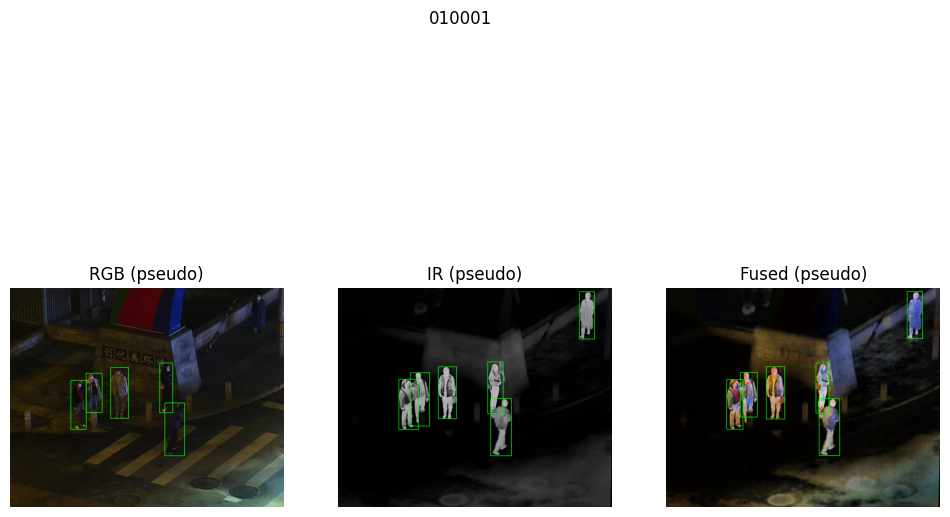

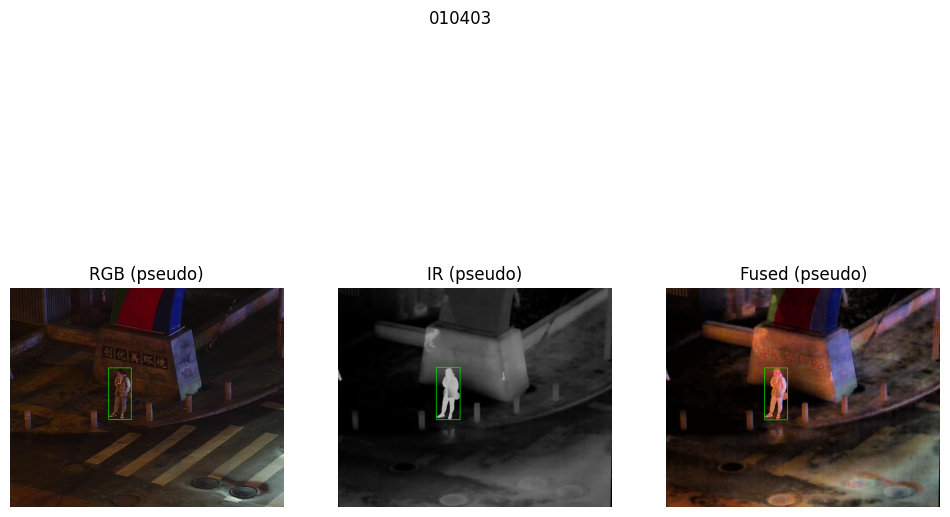

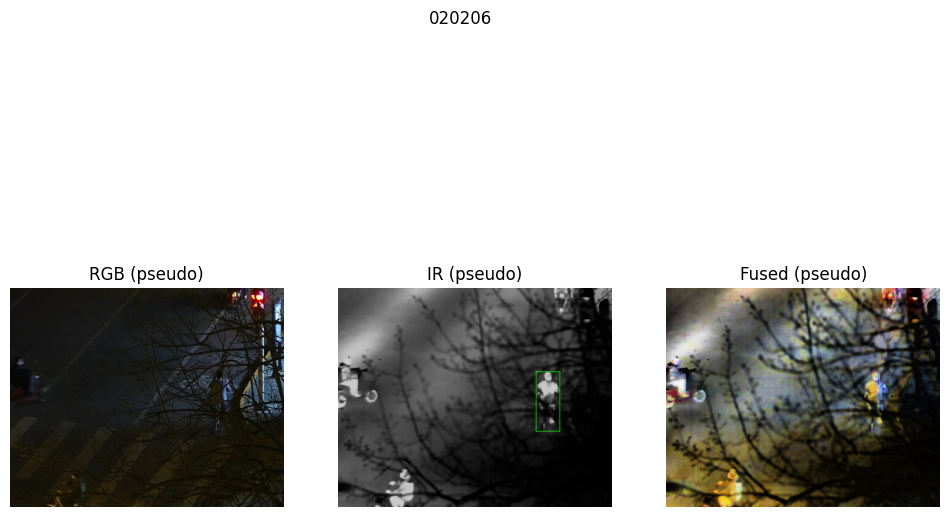

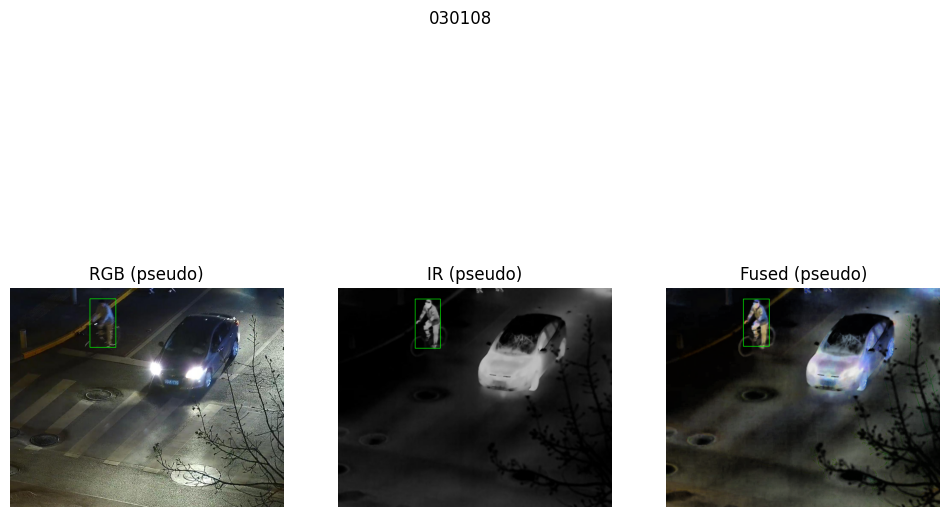

In [ ]:
# @title Visualize a few detections (RGB / IR / Fused)
def draw_boxes(img, anns):
    out = img.copy()
    for a in anns:
        x,y,w,h = a["bbox"]
        p1 = (int(x), int(y)); p2 = (int(x+w), int(y+h))
        cv2.rectangle(out, p1, p2, (0,255,0), 2)
    return out

sample_idxs = np.linspace(0, len(pairs)-1, num=min(4, len(pairs)), dtype=int)

for idx in sample_idxs:
    vis_path, ir_path = pairs[idx]
    rgb  = load_rgb(vis_path)
    ir   = load_ir(ir_path)
    fused = early_fusion(rgb, ir)
    ir3  = ir_to_3c(ir, rgb)

    stem = os.path.splitext(os.path.basename(vis_path))[0]
    # fetch anns by image_id (idx+1)
    img_id = idx + 1
    anns_rgb   = [a for a in coco_rgb["annotations"]   if a["image_id"] == img_id]
    anns_ir    = [a for a in coco_ir["annotations"]    if a["image_id"] == img_id]
    anns_fused = [a for a in coco_fused["annotations"] if a["image_id"] == img_id]

    disp_rgb   = draw_boxes(rgb,   anns_rgb)
    disp_ir    = draw_boxes(ir3,   anns_ir)
    disp_fused = draw_boxes(fused, anns_fused)

    plt.figure(figsize=(12,8))
    plt.subplot(1,3,1); plt.imshow(cv2.cvtColor(disp_rgb, cv2.COLOR_BGR2RGB)); plt.title("RGB (pseudo)")
    plt.axis("off")
    plt.subplot(1,3,2); plt.imshow(cv2.cvtColor(disp_ir, cv2.COLOR_BGR2RGB)); plt.title("IR (pseudo)")
    plt.axis("off")
    plt.subplot(1,3,3); plt.imshow(cv2.cvtColor(disp_fused, cv2.COLOR_BGR2RGB)); plt.title("Fused (pseudo)")
    plt.axis("off")
    plt.suptitle(stem); plt.show()


### 📊 Cell 8 — Quick “paper table” summary (counts per split)

In [ ]:
# @title Simple counts for your paper draft
def count_images_anns(coco):
    return len(coco["images"]), len(coco["annotations"])

print("RGB   -> images, anns:", count_images_anns(coco_rgb))
print("IR    -> images, anns:", count_images_anns(coco_ir))
print("Fused -> images, anns:", count_images_anns(coco_fused))


RGB   -> images, anns: (1205, 2109)
IR    -> images, anns: (1205, 2165)
Fused -> images, anns: (1205, 2152)
